# Module 3: Slightly more involved mPDF fits

Here, we do another mPDF fit for MnO using the atomic PDF fit residual, but we now add parameters to determine the sublattice spin direction and correlation length. We will also see how to estimate uncertainties from our fitting parameters.

We'll assume the atomic PDF fit has already been done, so we can jump right to the mPDF part.

In [35]:
### Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from diffpy.mpdf import *
from diffpy.structure import loadStructure

### Set all plots to be inline
%matplotlib notebook

The first several cells are identical to the previous tutorial, so you can just speed right through them.

#### Make the magnetic structure

In [36]:
# read in the mcif
mcif = 'files/1.31_MnO.mcif'
mstr = create_from_mcif(mcif, ffparamkey='Mn2')


# adjust the unit cell parameters to agree with the results of the structural fit
a_fit = 4.4328 # fill in the value from the fit
alpha_fit = 90.6434 # fill in the value from the fit
mstr.struc.lattice.a = 2*a_fit # multiply by two because the magnetic unit cell is 2x2x2 supercell of atomic cell
mstr.struc.lattice.b = 2*a_fit
mstr.struc.lattice.c = 2*a_fit
mstr.struc.lattice.alpha = alpha_fit
mstr.struc.lattice.beta = alpha_fit
mstr.struc.lattice.gamma = alpha_fit

mstr.makeAll()

MagStructure creation from mcif file successful.


#### Extract the data, load it into a Profile object

<IPython.core.display.Javascript object>


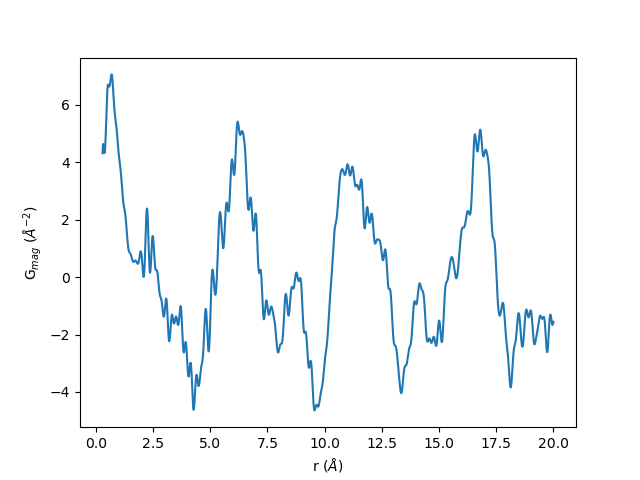

In [37]:
### The getDiffData function reads in a PDFgui fit file and extracts the fit residual
fit_file = 'files/MnOfit_PDFgui_NOMAD.fgr'
r, gobs, gcalc, gdiff = read_fgr(fit_file) # this extracts the results of the atomic PDF fit done in PDFgui
gmag = 1.0*gdiff # we set the experimental mPDF to the fit residual from the atomic PDF fit

### Let's plot it just to make sure it looks right

ax=plt.figure().add_subplot(111)
ax.plot(r, gmag, )
ax.set_xlabel(r"r ($\AA$)")
ax.set_ylabel(r"G$_{mag}$ ($\AA^{-2}$)")

plt.show()

#### Now we start building the fit in the diffpy.srfit framework

In [38]:
### Create a profile object and load the data into it
from diffpy.srfit.fitbase import Profile

profile = Profile()
profile.setObservedProfile(r, gmag)

#### Make the MPDFcalculator

In [48]:
### Create the MPDFcalculator
mc = MPDFcalculator(mstr)

### Set appropriate rmin and rmax
mc.rmin = profile.xobs.min()
mc.rmax = profile.xobs.max()

### Set the qdamp parameter determined from the experimental conditions
mc.qdamp = 0.025

#### Check the effect of the spin direction

Except for a few very high-symmetry cases, the mPDF will show some dependence on the spin direction. Let's look into that here.

[[ 0.10530043 -0.75717076  0.64467376]
 [ 0.10530043 -0.75717076  0.64467376]
 [ 0.10530043 -0.75717076  0.64467376]
 [ 0.10530043 -0.75717076  0.64467376]
 [ 0.10530043 -0.75717076  0.64467376]]


<IPython.core.display.Javascript object>


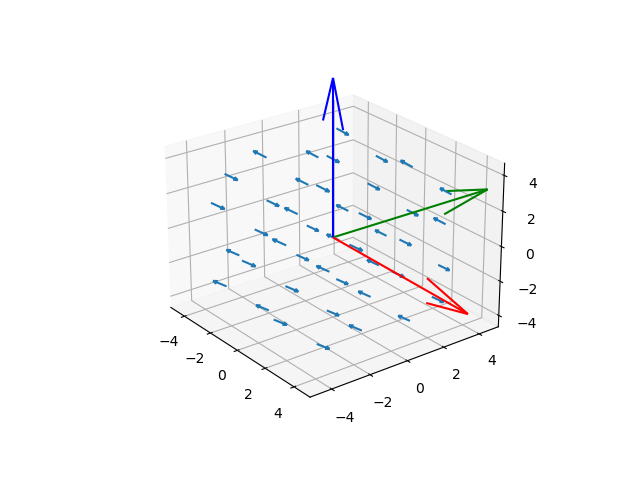

In [49]:
### Check the current orientation of the spins.
### Based on the mCIF file, they should be perpendicular to [111].
print(mstr.spins[:5])

### Let's visualize the spins.
distances = np.apply_along_axis(np.linalg.norm, 1, mstr.atoms)
mask = distances < 6
Smag = np.linalg.norm(mstr.spins[0])
mstr.visualize(mstr.atoms[mask], mstr.spins[mask]/Smag, showcrystalaxes=True) # divide by Smag to make the arrows a reasonable size

### Now alculate the mPDF for the current spin orientations. 
r1, gcalc1 = mc.calc()

Now we will change the orientation of the spins (while maintaining the same overall antiferromagnetic configuration) to see how this affects the mPDF. For magnetic structures with distinct sublattices (e.g. "spin up" and "spin down"), we can create numpy masks to select all spins from a given sublattice and change their orientations uniformly.

In [50]:
sublattice1 = np.all(mstr.spins == mstr.spins[0], axis=1) # select all spins that are identical to the first spin
sublattice2 = ~sublattice1 # select all other spins 

### Check that every spin in each sublattice is identical. What should the expressions below evaluate to?
print(np.max(mstr.spins[sublattice1] - mstr.spins[sublattice1][0]))
print(np.max(mstr.spins[sublattice2] - mstr.spins[sublattice2][0]))

### Now define a new spin direction and set the sublattices accordingly.
new_vec = np.array([0,0,1]) * Smag
mstr.spins[sublattice1] = new_vec
mstr.spins[sublattice2] = -new_vec

### Now calculate the mPDF with this new spin orientation.
r2, gcalc2 = mc.calc()

0.0
0.0


Define two more arbitrary spin directions for additional comparions. Be sure that the total length of the spin vector is Smag so that we can compare the mPDF patterns for easily. Then plot the 4 calculated mPDF patterns together to see how similar or different they are.

<IPython.core.display.Javascript object>


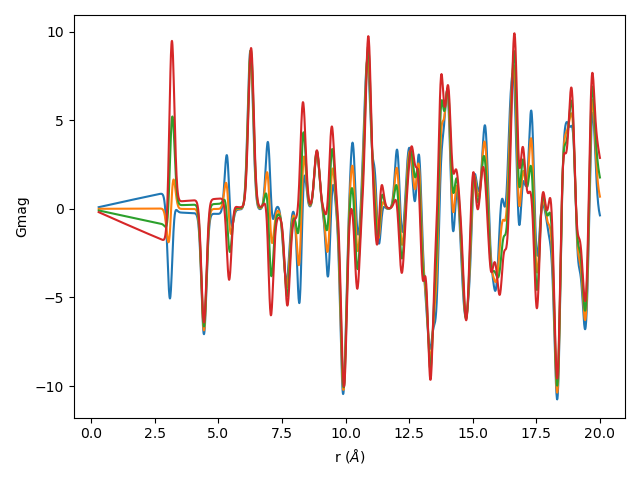

In [51]:
new_vec = np.array([0,1,1]) / np.sqrt(2) * Smag
mstr.spins[sublattice1] = new_vec
mstr.spins[sublattice2] = -new_vec
r3, gcalc3 = mc.calc()

new_vec = np.array([1,1,1]) / np.sqrt(3) * Smag
mstr.spins[sublattice1] = new_vec
mstr.spins[sublattice2] = -new_vec
r4, gcalc4 = mc.calc()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('Gmag')

ax.plot(r1, gcalc1)
ax.plot(r2, gcalc2)
ax.plot(r3, gcalc3)
ax.plot(r4, gcalc4)

plt.tight_layout()
plt.show()

Finally, let's define one more spin direction, this one randomly generated by constrained to be perpendicular to the [111] direction. We'll compare it to the original spin direction, which was also perpendicular to [111]. What does the result imply about the ability of 1D-mPDF to distinguish between different spin orientations within the plane perpendicular to [111]?

<IPython.core.display.Javascript object>


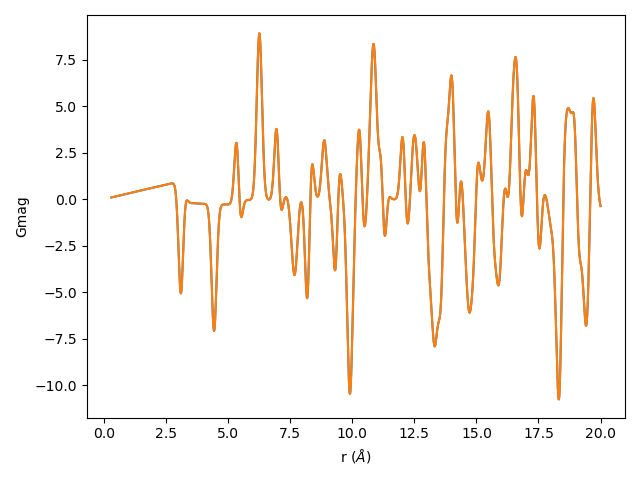

In [52]:
random = np.random.uniform()
new_vec = np.array([random, random, -2*random])
new_vec = new_vec / np.linalg.norm(new_vec) * Smag
mstr.spins[sublattice1] = new_vec
mstr.spins[sublattice2] = -new_vec
r5, gcalc5 = mc.calc()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('Gmag')

ax.plot(r1, gcalc1)
ax.plot(r5, gcalc5)

plt.tight_layout()
plt.show()

#### Continue with the fit
Now we know the mPDF is sensitive to the spin direction up to directions within the plane perpendicular to [111]. Let's proceed with the fit.

In [53]:
### Make the FitContribution
from diffpy.srfit.fitbase import FitContribution
mfit = FitContribution('mfit')
mfit.setProfile(profile)

Now we define an mPDF function that includes parameters for the spin orientation. We will use the spherical coordinates theta (polar angle) and phi (azimuthal angle) to parameterize the spin direction. We will also add in the correlation length as a parameter (although we are in the long-range ordered state of MnO at 5 K, so this parameter is not actually necessary to include in this case).

In [54]:
### Define the function that will calculate the mPDF.
def mpdf(parascale, ordscale, theta, phi, xi):
    ### parascale sets the magnitude of the self-scattering peak below ~1 A
    ### ordscale sets the magnitude of the mPDF
    mc.paraScale, mc.ordScale = parascale, ordscale
    mstr.corrLength = xi
    sx = np.sin(theta) * np.cos(phi)
    sy = np.sin(theta) * np.sin(phi)
    sz = np.cos(theta)
    new_vec = np.array([sx, sy, sz])
    mstr.spins[sublattice1] = new_vec
    mstr.spins[sublattice2] = -new_vec
    rcalc, gcalc, dcalc = mc.calc(both=True)
    # we want to return the "unnormalized" mPDF dcalc
    return dcalc

### Now we load this function into our FitContribution
mfit.registerFunction(mpdf)

### Now we set the equation that the FitContribution will evaluate during the fit
mfit.setEquation("mpdf(parascale, ordscale, theta, phi, xi)")

In [59]:
### Make the FitRecipe
from diffpy.srfit.fitbase import FitRecipe
recipe = FitRecipe()

### Give the PDFContribution to the FitRecipe
recipe.addContribution(mfit)

### Add the mPDF variables
recipe.addVar(mfit.parascale, 0.1) # 0.1 is the starting value
recipe.addVar(mfit.ordscale, 0.1)
recipe.addVar(mfit.theta, np.pi/2)
restraint_theta = recipe.restrain(mfit.theta,lb=0,ub=np.pi,sig=0.0001) # restrict theta to [0, Pi]
recipe.addVar(mfit.phi, 0)
restraint_phi = recipe.restrain(mfit.phi,lb=-np.pi,ub=np.pi,sig=0.0001) # restrict phi to [-Pi, Pi]
recipe.addVar(mfit.xi,100)

#### Run the refinement

Refine using scipy's least-squares optimizer:
  variables: ['parascale', 'ordscale', 'theta', 'phi', 'xi']
  initial values: [  0.1          0.1          1.57079633   0.         100.        ]
  final values: [  0.22935552   0.15675771   1.05502011  -1.27223742 100.10455239]


<IPython.core.display.Javascript object>


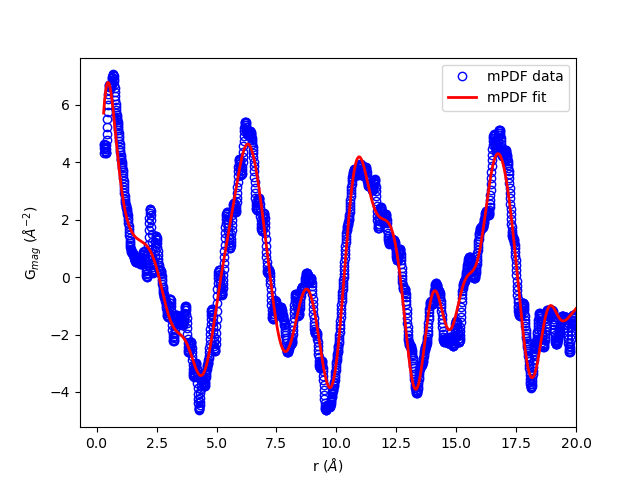

In [60]:
# Turn off printout of iteration number.
recipe.clearFitHooks()

print("Refine using scipy's least-squares optimizer:")
print("  variables:", recipe.names)
print("  initial values:", recipe.values)

from scipy.optimize import least_squares

# This is where we run the least squares minimization
optimized = least_squares(recipe.residual, recipe.values)
print("  final values:", recipe.values)

### Plot the results
fit = mfit.evaluateEquation("mpdf")
mdiff = gmag - fit

ax=plt.figure().add_subplot(111)
ax.plot(r, gmag, 'bo', label="mPDF data", markerfacecolor='none', markeredgecolor='b')
ax.plot(r, fit, 'r-', lw=2, label="mPDF fit")
ax.set_xlabel(r"r ($\AA$)")
ax.set_ylabel(r"G$_{mag}$ ($\AA^{-2}$)")
ax.set_xlim(xmax=mc.rmax)
plt.legend(loc=1)

plt.show()

<IPython.core.display.Javascript object>


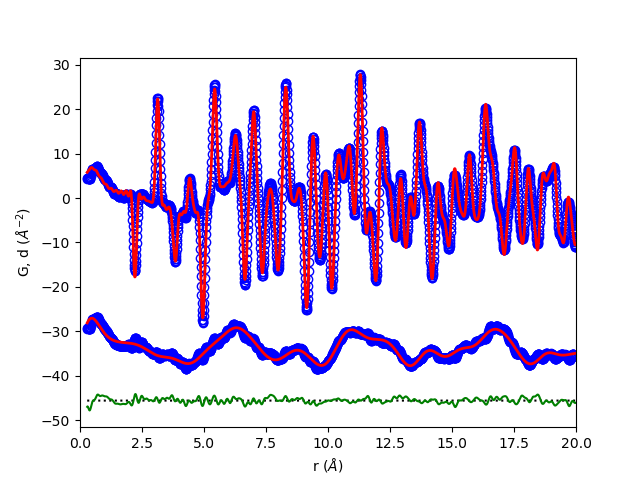

In [61]:
### Plot the total PDF (atomic + magnetic) with the total fit

offset1 = 1.2*gobs.min()
offset2 = offset1 - 8*mdiff.max()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(r,gobs,marker='o',mfc='none',mec='b',linestyle='none') ### total observed PDF pattern 
ax.plot(r,gcalc + fit,'r-',lw=2) ### calculated atomic PDF
ax.plot(r,gmag+offset1,marker='o',mfc='none',mec='b',linestyle='none') ### residual from atomic PDF fit
ax.plot(r,fit+offset1,'r-',lw=2) ### calculated mPDF
ax.plot(r,np.zeros_like(r)+offset2,'k:')
ax.plot(r,mdiff+offset2,'g-') ### overall fit residual after including atomic and magnetic PDFs
ax.set_xlim(xmin=0,xmax=mc.rmax)
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('G, d ($\AA^{-2}$)')

plt.show()

In [62]:
plt.close('all')

Now you can print out the spins and see what direction the refined to. The published magnetic structure of MnO has the spins perpendicular to the [111] direction. Is that the case for your fit?

In [76]:
print(mstr.spins[0], mstr.spins[-1])
print(np.dot(mstr.spins[0], np.array([1,1,1])))

[-0.72239481  0.05215733  0.68951095] [ 0.72239481 -0.05215733 -0.68951095]
0.01927346036325972


Now we calculate the estimated uncertainties on the fitting parameters. This is determined from the least squares fitting routine. We use the function getStdUnc included in diffpy.mpdf to calculate this. Run the cell below to see what arguments the function needs. Note that our PDF data did not come with any uncertainties and we haven't applied any constraints to our variables.

In [63]:
getStdUnc?

In [64]:
### Calculate and display the uncertainties for each parameter
uncertainties = getStdUnc(optimized, profile.y)[0]
for idx, item in enumerate(zip(recipe.names, recipe.values)):
    print(item[0], item[1], uncertainties[idx])

parascale 0.2293555155201789 0.011321179705774094
ordscale 0.15675771175411818 0.0025433069397074503
theta 1.0550201129217436 80.55559399201412
phi -1.2722374215302765 87.0102510427632
xi 100.1045523914752 12.591313307511095


What do you notice about the size of the uncertainties for theta and phi? Why do you think this is the case?

We can also calculate the ordered moment with its propagated uncertainty. To do so, we again use the function calculate_ordered_moment, but now we pass the optional keywords to enable the error estimation.

In [66]:
nucScale = 0.05277
unc_ord = uncertainties[1]
unc_xi = uncertainties[4]
unc_nuc = 0.001
calculate_ordered_moment(mc, nucScale, returnUncertainty=True, inputUnc=[unc_ord, unc_nuc, unc_xi])

(4.931587314251967, 0.06322057872152552)

### Alternative method that does not use diffpy.srfit

diffpy.srfit provides a flexible framework for doing mPDF fits, but you are not required to use it. Below is an example of a fit that is done without diffpy.srfit. Note that we create the magnetic structure by setting the propagation vectors and basis vectors in this example, though we could just as well have used the mCIF approach.

In [69]:
### Get the data
fit_file = 'files/MnOfit_PDFgui_NOMAD.fgr'
r, gobs, gcalc, gdiff = read_fgr(fit_file) # this extracts the results of the atomic PDF fit done in PDFgui
gmag = 1.0*gdiff # we set the experimental mPDF to the fit residual from the atomic PDF fit


### Make the magnetic structure
struc = loadStructure('files/MnO_struc_NOMAD.stru')

svec = np.array([0,0,1]) # start with an incorrect spin orientation to ensure we converge to the right direction
mspec = MagSpecies(struc, strucIdxs=[0,1,2,3], ffparamkey='Mn2', rmaxAtoms=r.max(),
                 basisvecs=svec, kvecs=np.array([0.5,0.5,0.5]), label='Mn')

mstr=MagStructure()
mstr.loadSpecies(mspec)
mstr.makeAll()


### Make the calculator
mc = MPDFcalculator(mstr)
mc.rmin = r.min()
mc.rmax = r.max()
mc.qdamp = 0.025

Now we define a residual function that allows the spin direction to vary. We'll leave the correlation length out of this fit.

In [73]:
def residual(p,ydata):
    oscale, pscale, th, phi = p
    sx = np.sin(th)*np.cos(phi)
    sy = np.sin(th)*np.sin(phi)
    sz = np.cos(th)
    newsvec = np.array([sx, sy, sz])
    mspec.basisvecs = newsvec
    mstr.makeSpins()
    mc.ordScale = oscale
    mc.paraScale = pscale
    return ydata - mc.calc(both=True)[2]

Now we run the least-squares routine and plot the result.

<IPython.core.display.Javascript object>


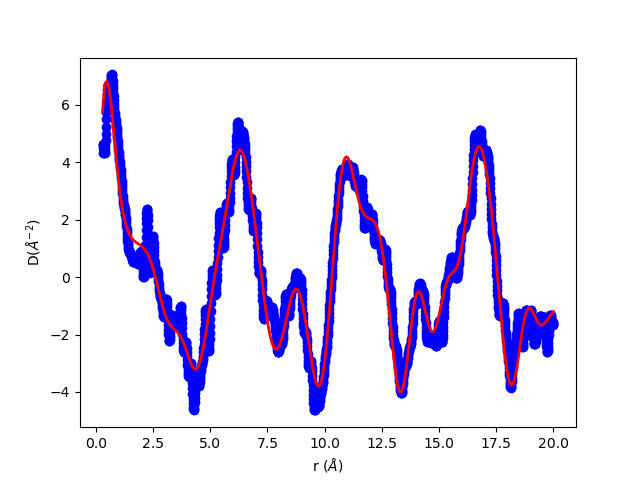

In [74]:
p0 = [0.1,0.1,np.arccos(np.random.uniform(-1,1)),np.random.uniform(-np.pi,np.pi)]
optimized = least_squares(residual,p0,bounds=[[0,0,0,-np.pi],[10,10,np.pi,np.pi]], args=(gmag,))
fit = mc.calc(both=True)[2]

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(r,gmag,'bo',linestyle='none')
ax.plot(r,fit,'r-',lw=2)
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('D($\AA^{-2}$)')

plt.show()    

In [77]:
plt.close('all')